In [1]:
import pandas as pd
import sys
sys.path.append("..")
from utility import utility_functions as utf
from utility.db_util import db_reader
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras import layers
from keras_tuner import Hyperband
import pickle


In [2]:
sql = """
        SELECT *
        FROM under_11min_ride_df
"""
df = db_reader(sql,'post_procces_data')

In [3]:
df = utf.get_dummies(['weekday','time_binned'],df)

In [7]:
y,X = utf.split_X_y(df,'num_of_taxis')

In [8]:
X_train_scaler = StandardScaler()
X_test_scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1357)

X_train_scaled = X_train_scaler.fit_transform(X_train)
X_test_scaled = X_test_scaler.fit_transform(X_test)

In [9]:
# Option One, Rmse about ~68 but will return nan's after some iteration.
def build_model(hp):
  model = keras.Sequential()
  
  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
  hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
  hp_units3 = hp.Int('units3', min_value=32, max_value=512, step=32)
  hp_units4 = hp.Int('units4', min_value=32, max_value=512,step=32)
  model.add(layers.Dense(units=hp_units1, activation='relu'))
  model.add(layers.Dense(units=hp_units2, activation='relu'))
  model.add(layers.Dense(units=hp_units3, activation='relu'))
  model.add(layers.Dense(units=hp_units4, activation='relu'))
  model.add(layers.Dense(1, kernel_initializer='normal', activation='linear'))


  model.compile(
      optimizer=keras.optimizers.Adam(),
      loss='mse',
      metrics=['mse']
  )
  return model

In [9]:
# # Option Two, around 59 RMSE but no result for the nans in the loss functions
# def build_model(hp):
#   model = keras.Sequential()
  
#   # Tune the number of units in the first Dense layer
#   # Choose an optimal value between 32-512
#   hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
#   hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
#   hp_units3 = hp.Int('units3', min_value=32, max_value=512, step=32)
#   model.add(layers.Dense(units=hp_units1, activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)))
#   model.add(layers.Dense(units=hp_units2, activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)))
#   model.add(layers.Dense(units=hp_units3, activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)))
#   model.add(layers.Dense(1, kernel_initializer='normal', activation='linear'))

#   # Tune the learning rate for the optimizer
#   # Choose an optimal value from 0.01, 0.001, or 0.0001

#   model.compile(
#       optimizer=keras.optimizers.Adam(clipnorm=1.0),
#       loss=root_mean_squared_error_loss,
#       metrics=[RootMeanSquaredError()]
#   )
#   return model

In [10]:
tuner = Hyperband(
    build_model,
    objective='mse',
    max_epochs=10,
    directory='keras_tuner_mse',
    project_name='nyc-taxi-demand-predication'
)

In [11]:
tuner.search(X_train_scaled, y_train, epochs=10, validation_split=0.2)

Trial 30 Complete [00h 00m 52s]
mse: 6405.57861328125

Best mse So Far: 5744.04833984375
Total elapsed time: 00h 14m 49s
INFO:tensorflow:Oracle triggered exit


In [12]:
for h_param in [f"units{i}" for i in range(1,4)]:
  print(h_param, tuner.get_best_hyperparameters()[0].get(h_param))

units1 320
units2 256
units3 320


In [21]:
best_model = tuner.get_best_models()[0]
best_model.build(X_train_scaled.shape)
best_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (103744, 320)             13440     
                                                                 
 dense_1 (Dense)             (103744, 256)             82176     
                                                                 
 dense_2 (Dense)             (103744, 320)             82240     
                                                                 
 dense_3 (Dense)             (103744, 352)             112992    
                                                                 
 dense_4 (Dense)             (103744, 1)               353       
                                                                 
Total params: 291,201
Trainable params: 291,201
Non-trainable params: 0
_________________________________________________________________


In [18]:

from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)

Epoch 1/100
325/325 [==============================] - 2s 5ms/step - loss: 4782.5566 - mse: 4782.5566 - val_loss: 4848.6021 - val_mse: 4848.6021
Epoch 2/100
325/325 [==============================] - 2s 5ms/step - loss: 4371.5298 - mse: 4371.5298 - val_loss: 4675.3594 - val_mse: 4675.3594
Epoch 3/100
325/325 [==============================] - 2s 5ms/step - loss: 4238.5181 - mse: 4238.5181 - val_loss: 4569.6240 - val_mse: 4569.6240
Epoch 4/100
325/325 [==============================] - 2s 5ms/step - loss: 4123.0303 - mse: 4123.0303 - val_loss: 4425.6470 - val_mse: 4425.6470
Epoch 5/100
325/325 [==============================] - 2s 5ms/step - loss: 3958.1543 - mse: 3958.1543 - val_loss: 4233.4541 - val_mse: 4233.4541
Epoch 6/100
325/325 [==============================] - 2s 5ms/step - loss: 3900.5308 - mse: 3900.5308 - val_loss: 4478.7759 - val_mse: 4478.7759
Epoch 7/100
325/325 [==============================] - 2s 5ms/step - loss: 3766.6311 - mse: 3766.6311 - val_loss: 4126.1938 - val_

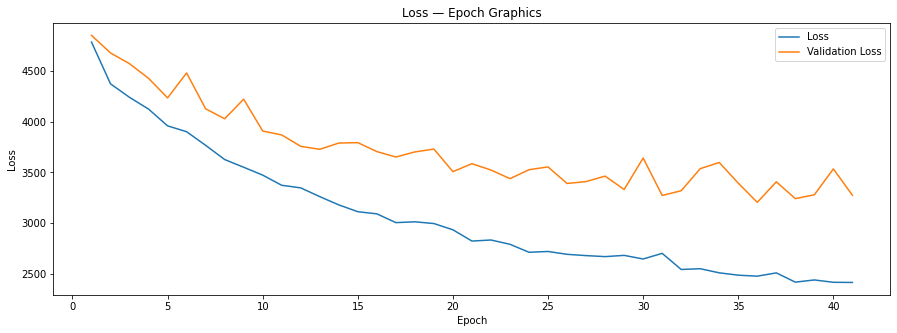

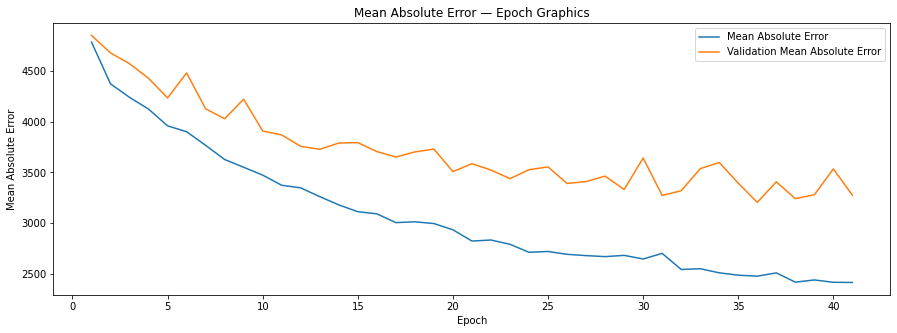

In [22]:

hist = best_model.fit(
    X_train_scaled, 
    y_train,
    epochs=100,
    batch_size=256,
    validation_split=0.2,
    callbacks =[earlystopping]

)
import matplotlib.pyplot as plt
figure = plt.gcf()
figure.set_size_inches((15, 5))
plt.title('Loss — Epoch Graphics')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(1, len(hist.history['loss']) + 1), hist.history['loss'])
plt.plot(range(1, len(hist.history['val_loss']) + 1), hist.history['val_loss'])
plt.legend(['Loss', 'Validation Loss'])
plt.show()
figure = plt.gcf()
figure.set_size_inches((15, 5))
plt.title('Mean Square Error — Epoch Graphics')
plt.xlabel('Epoch')
plt.ylabel('Mean Square Error')
plt.plot(range(1, len(hist.history['mse']) + 1), hist.history['mse'])
plt.plot(range(1, len(hist.history['val_mse']) + 1), hist.history['val_mse'])
plt.legend(['Mean Square Error', 'Validation Mean Square Error'])
plt.show()